<a href="https://colab.research.google.com/github/HomeschoolHarry/forecast_testing_Darts/blob/main/forecast_testing_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs and Imports

## <u>Comparing Darts forecasting models against Tito Vodka sales in Iowa <u>


API to Iowa Liquor Database:
- Link to Iowa API: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy
- Link to seperate technical write up that was previously published with imformation on dataset and SODA API:https://medium.com/@harry.mckaig/building-a-data-pipeline-from-the-iowa-liquor-sales-open-database-using-socrata-open-data-api-f21875dd6f2c

API will grab
- Tito's (750mL bottle, 12 pack ONLY) sales and volume
- All Other (A/O): total sales and volume

- Sales it total retail dollars (retail bottle price * number of bottles sold)
- Volume is total liters sold (converted to standard 9L cases)

In [ ]:
import os

In [ ]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.2/370.2 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.

In [ ]:
import numpy as np
import requests
import seaborn as sns
import pandas as pd
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

Iowa Liquor API

In [29]:
# Grab Tito's 750mL using item Code and All-Other A/O category sales
# use "where funtion to fix 2012 through Dec 2022"
url = f"https://data.iowa.gov/resource/m3tr-qhgy.json?$select=date_trunc_ym(date) as date,itemno='38176' as tito_750,sum(sale_dollars) as sales,sum(sale_liters) as volume&$group=date,tito_750&$where=date between '2012-01-01T00:00:00' and '2022-12-31T00:00:00'"
response = requests.get(url)
response.raise_for_status()

# To save as Pandas DataFrame
titos = response.json()
titos = pd.DataFrame(titos)

#convert types
convert_dict = {'date': object,
                'sales': float,
                'volume': float,
                }
titos = titos.astype(convert_dict)

# use numpy to convert year and month to datetime
titos['date'] = pd.to_datetime(titos['date'])

# grab 750 ml using True value
tito_750_only = titos[titos['tito_750'] == True]
#drop the boolean column
tito_750_only = tito_750_only.drop('tito_750', axis=1)

#grab all-other sales
ao_sales = titos[titos['tito_750'] == False]
ao_sales = ao_sales.drop('tito_750', axis=1)

# Volume DataFrames
df_tito_volume = tito_750_only[['date', 'volume']]
df_ao_volume = ao_sales[['date', 'volume']]

Convert to 9L

In [30]:
# convert to standard 9L cases
def conv_nine(row):
  return (row['volume'] / 9).round(decimals=0)

df_tito_volume['volume (9L)'] = conv_nine(df_tito_volume)
df_ao_volume['volume (9L)'] = conv_nine(df_ao_volume)

df_tito_volume = df_tito_volume.drop(columns='volume')
df_ao_volume = df_ao_volume.drop(columns='volume')

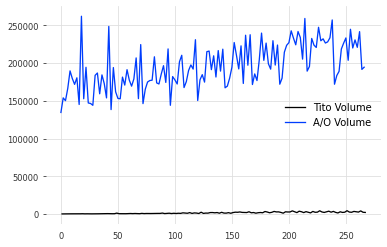

In [ ]:
df_tito_volume['volume (9L)'].plot(label="Tito Volume")
df_ao_volume['volume (9L)'].plot(label="A/O Volume")
plt.legend();

In [31]:
# Convert sales to Series
series_tito_sales = TimeSeries.from_dataframe(tito_750_only,time_col='date')
series_ao_sales = TimeSeries.from_dataframe(ao_sales, time_col='date')

# Convert volume to Series
series_tito_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')
series_ao_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')

In [32]:
# Fit and Transform Data
scaler_tito, scaler_ao = Scaler(), Scaler()
series_tito_scaled = scaler_tito.fit_transform(series_tito_volume)
series_ao_scaled = scaler_ao.fit_transform(series_ao_volume)

# series_tito_scaled.plot(label="Tito Volume")
# series_ao_scaled.plot(label="A/O Volume")
# plt.legend();

## Training / Test Split

We want to test out 6 months and will take length of series, subtract 6 for the train /test split

In [33]:
len(series_ao_volume)

132

In [ ]:
#only using if fixing time periods
from datetime import datetime
now = datetime.now()

In [ ]:
series_tito_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')
series_ao_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')

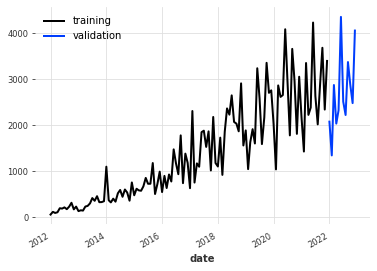

In [34]:
#Tito's 750mL only 
train, val = series_tito_volume.split_before(120) 
train.plot(label="training")
val.plot(label="validation")

#to check validation lenght
#print(len(val))

## Create dataframe for results

In [75]:
df_results = pd.DataFrame

In [86]:
df_results = df_tito_volume.tail(12)

In [87]:
df_results

,date,volume (9L)
241,2022-01-01,2076.0
243,2022-02-01,1343.0
245,2022-03-01,2872.0
247,2022-04-01,2034.0
249,2022-05-01,2324.0
251,2022-06-01,4352.0
253,2022-07-01,2511.0
255,2022-08-01,2221.0
257,2022-09-01,3371.0
259,2022-10-01,2883.0


In [145]:
val[0:3]
type(val)

darts.timeseries.TimeSeries

## Naive - Random Walk Model

In [98]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)

# The fit() function takes in argument the training time series on which to fit the model
naive_model.fit(train)

# the predict() function takes an argument, the number of time steps (after the end of the training series) over which to forecast.
# the number of stepts in this model will be in months
naive_forecast_3 = naive_model.predict(3)
naive_forecast_6 = naive_model.predict(6)
naive_forecast_12 = naive_model.predict(12)

print(naive_forecast_3)
print(mape(val[0:3], naive_forecast_3))

#print(naive_forecast_6)
print(mape(val[0:6], naive_forecast_6))

#print(naive_forecast_3)
print(mape(val, naive_forecast_12))

# val.plot(label="actual")
# naive_forecast.plot(label="naive forecast (K=1)")


<TimeSeries (DataArray) (date: 3, component: 1, sample: 1)>
array([[[3395.]],

       [[3395.]],

       [[3395.]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 2022-03-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
78.17940267390348
61.58748713098971
44.10724264365424


In [147]:
type(naive_forecast_12)

darts.timeseries.TimeSeries

## Moving Averages: 3, 6, 12 month

In [243]:
#use index to grab months 
MA_3 = df_tito_volume['volume (9L)'][117:120].mean()
MA_6 = df_tito_volume['volume (9L)'][114:120].mean()
MA_12 = df_tito_volume['volume (9L)'][108:120].mean()
# MA_3, MA_6, MA_12


# # MAPE manual to avoid type conversions from Darts
# def manual_mape(ma, months):
#   absolut_dif = [] # save to averge total
#   val_series = val[0:months] #pulls number of months from validation set
#   for x in val_series:
#     print(abs(ma-x))
#   #   absolut_dif.append(pe)
#   # print(absolut_dif)
#   # print(type(absolut_dif))

# manual_mape(MA_3, 3)


# # 3 Months over 3,6,12 month periods
MA_3_APE_3M = (abs((MA_3 * 3) - val[0:3].values().sum())) / val[0:3].values().sum()
MA_3_APE_6M = (abs((MA_3 * 6) - val[0:6].values().sum())) / val[0:6].values().sum()
MA_3_APE_12M = (abs((MA_3 * 12) - val.values().sum())) / val.values().sum()

# # # 3 Months over 3,6,12 month periods
MA_6_APE_3M = (abs((MA_6 * 3) - val[0:3].values().sum())) / val[0:3].values().sum()
MA_6_APE_6M = (abs((MA_6 * 6) - val[0:6].values().sum())) / val[0:6].values().sum()
MA_6_APE_12M = (abs((MA_6 * 12) - val.values().sum())) / val.values().sum()

# # # 3 Months over 3,6,12 month periods
MA_12_APE_3M = (abs((MA_12 * 3) - val[0:3].values().sum())) / val[0:3].values().sum()
MA_12_APE_6M = (abs((MA_12 * 6) - val[0:6].values().sum())) / val[0:6].values().sum()
MA_12_APE_12M = (abs((MA_12 * 12) - val.values().sum())) / val.values().sum()



In [245]:
print(MA_3_APE_3M, MA_3_APE_6M, MA_3_APE_12M) #3MA APE accross 3,6,12 months
print(MA_6_APE_3M, MA_6_APE_6M, MA_6_APE_12M) #6MA APE accross 3,6,12 months
print(MA_12_APE_3M, MA_12_APE_6M, MA_12_APE_12M) #12MA APE accross 3,6,12 months

0.49658241932920044 0.2552496500233318 0.1580209710648504
0.34748052773803845 0.1301913205786281 0.04264936502567572
0.30054840247973297 0.09082727818145457 0.0063343685618523415


In [101]:

df_tito_volume.tail

,date,volume (9L)
217,2021-01-01,2163.0
219,2021-02-01,1427.0
221,2021-03-01,3350.0
223,2021-04-01,2223.0
225,2021-05-01,2381.0
227,2021-06-01,4229.0
229,2021-07-01,2634.0
231,2021-08-01,2017.0
233,2021-09-01,2888.0
235,2021-10-01,3681.0


## Naive - Random Walk Model w/ Seasonality

Absolute Error on 3 month = 0.10316324908599586
Absolute Error on 6 month = 0.051463235784281046
Absolute Error on 12 month = 0.0063343685618523415
9.029619748107399
6.943308203561961
9.972881800912644
9.029619748107399
6.943308203561961
9.972881800912644
<TimeSeries (DataArray) (date: 12, component: 1, sample: 1)>
array([[[2163.]],

       [[1427.]],

       [[3350.]],

       [[2223.]],

       [[2381.]],

       [[4229.]],

       [[2634.]],

       [[2017.]],

       [[2888.]],

       [[3681.]],

       [[2339.]],

       [[3395.]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


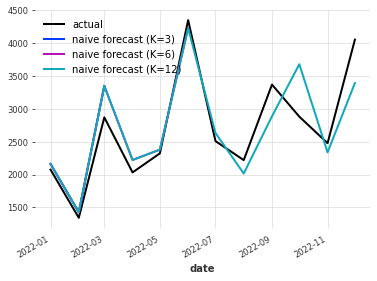

In [277]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast_3 = seasonal_model.predict(3) #3 Months
seasonal_forecast_6 = seasonal_model.predict(6) #6 Months
seasonal_forecast_12 = seasonal_model.predict(12) #12 Months

# Absolute Error
# # 3 Months over 3,6,12 month periods
seasonal_forecast_3_A = (abs((seasonal_forecast_3.values().sum()) - val[0:3].values().sum())) / val[0:3].values().sum()
seasonal_forecast_6_A = (abs((seasonal_forecast_6.values().sum()) - val[0:6].values().sum())) / val[0:6].values().sum()
seasonal_forecast_12_A = (abs((seasonal_forecast_12.values().sum()) - val.values().sum())) / val.values().sum()

print(f'Absolute Error on 3 month = {seasonal_forecast_3_A}')
print(f'Absolute Error on 6 month = {seasonal_forecast_6_A}')
print(f'Absolute Error on 12 month = {seasonal_forecast_12_A}')

# Plot Forecast
val.plot(label="actual")
seasonal_forecast_3.plot(label="naive forecast (K=3)")
seasonal_forecast_6.plot(label="naive forecast (K=6)")
seasonal_forecast_12.plot(label="naive forecast (K=12)")

# MAPE on Validation Set
print(mape(val[0:3], seasonal_forecast_3))
print(mape(val[0:6], seasonal_forecast_6))
print(mape(val, seasonal_forecast_12))

print(seasonal_forecast_12)

## Naive - Combined drift and seasonal
- This model simply produces linear predictions, with a slope that is determined by the first and last values of the training set

Mean absolute percentage error for the combined naive drift + seasonal: 11.04%.


<TimeSeries (DataArray) (date: 12, component: 1, sample: 1)>
array([[[2191.04201681]],

       [[1483.08403361]],

       [[3434.12605042]],

       [[2335.16806723]],

       [[2521.21008403]],

       [[4397.25210084]],

       [[2830.29411765]],

       [[2241.33613445]],

       [[3140.37815126]],

       [[3961.42016807]],

       [[2647.46218487]],

       [[3731.50420168]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

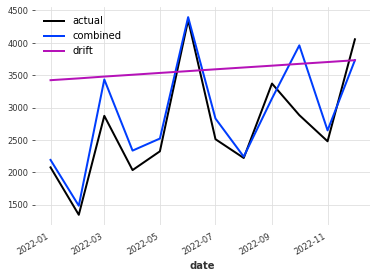

In [275]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(12) #12 months

combined_forecast = drift_forecast + seasonal_forecast_12 - train.last_value()

val.plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(val, combined_forecast)
    )
)

\

## Testing Dart models (based on Sci-Kit Learn Models)

3 Month

In [282]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta, ARIMA


def eval_model(model):
    model.fit(train)
    forecast = model.predict(3) 
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val[0:3], forecast)))
    print(forecast)
    print(forecast.values().sum())


print(eval_model(ExponentialSmoothing()))
print(eval_model(TBATS()))
print(eval_model(AutoARIMA()))
print(eval_model(Theta()))
print(eval_model(ARIMA()))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 20.19%
<TimeSeries (DataArray) (date: 3, component: 1, sample: 1)>
array([[[2416.38918198]],

       [[1666.31746834]],

       [[3449.0560551 ]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 2022-03-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
7531.762705413006
None
model (T)BATS obtains MAPE: 37.59%
<TimeSeries (DataArray) (date: 3, component: 1, sample: 1)>
array([[[2485.27812797]],

       [[2451.50740535]],

       [[2569.6623744 ]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 2022-03-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
7506.447907720422
None
model Auto-ARI

6 Month

In [283]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta, ARIMA


def eval_model(model):
    model.fit(train)
    forecast = model.predict(6) 
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val[0:6], forecast)))
    print(forecast)
    print(forecast.values().sum())


print(eval_model(ExponentialSmoothing()))
print(eval_model(TBATS()))
print(eval_model(AutoARIMA()))
print(eval_model(Theta()))
print(eval_model(ARIMA()))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 17.79%
<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)>
array([[[2416.38918198]],

       [[1666.31746834]],

       [[3449.0560551 ]],

       [[2580.26985314]],

       [[2720.51019667]],

       [[4449.49554846]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-06-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
17282.038303684385
None
model (T)BATS obtains MAPE: 34.50%
<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)>
array([[[2485.27812797]],

       [[2451.50740535]],

       [[2569.6623744 ]],

       [[2832.88523953]],

       [[3206.71295938]],

       [[3613.95328342]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-06-01
  * component  (compone

12 Month

In [284]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta, ARIMA


def eval_model(model):
    model.fit(train)
    forecast = model.predict(12) 
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))
    print(forecast)
    print(forecast.values().sum())


print(eval_model(ExponentialSmoothing()))
print(eval_model(TBATS()))
print(eval_model(AutoARIMA()))
print(eval_model(Theta()))
print(eval_model(ARIMA()))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 15.43%
<TimeSeries (DataArray) (date: 12, component: 1, sample: 1)>
array([[[2416.38918198]],

       [[1666.31746834]],

       [[3449.0560551 ]],

       [[2580.26985314]],

       [[2720.51019667]],

       [[4449.49554846]],

       [[3021.73505962]],

       [[2304.24100762]],

       [[3355.63103454]],

       [[3866.70091823]],

       [[2627.50904918]],

       [[3496.17885014]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
35954.0342229994
None
model (T)BATS obtains MAPE: 37.59%
<TimeSeries (DataArray) (date: 12, component: 1, sample: 1)>
array([[[2485.27812797]],

       [[2451.50740535]],

       [[2569.6623744 ]],

       [[2832.88523953]],

  

Absolut Value Based on Models

In [ ]:
# Summing Absolut Values for 3 month



# Summing Absolut Values for 6 month




# Summing Absolut Values for 12 month

FINDING BEST THETA

In [ ]:
# # Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(7)
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(7)

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)



In [ ]:

#train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

In [ ]:
pred_best_theta

BACKTESTING

In [ ]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series_tito_volume, start=0.6, forecast_horizon=6, verbose=True
)

series_tito_volume.plot(label="data")
historical_fcast_theta.plot(label="backtest 7-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series_tito_volume)))

In [ ]:
historical_fcast_theta
#pred_best_theta


In [ ]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series_tito_volume, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
average_error = best_theta_model.backtest(
    series_tito_volume,
    start=0.6,
    forecast_horizon=6,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series_tito_volume))

In [ ]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series_tito_volume, start=0.6, forecast_horizon=7, verbose=True
)

In [ ]:
series_tito_volume.plot(label="data")
historical_fcast_es.plot(label="backtest 7-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series_tito_volume)))

MACHING LEARNING

In [ ]:
len(train)

## NBEATS

In [ ]:
# Create model 
from darts.models import NBEATSModel

#134 total months (minus 7) = 127

model = NBEATSModel(input_chunk_length=127, output_chunk_length=7, random_state=42)

model.fit(series_tito_scaled, epochs=50, verbose=True);



In [ ]:
pred_volume = model.predict(series=series_tito_scaled, n=36)

# scale back:
pred_volume = Scaler.inverse_transform(pred_volume)

plt.figure(figsize=(10, 6))
series_tito_scaled.plot(label="actual volume")
pred_volume.plot(label="forecast volume")

In [ ]:
type(pred_volume)

In [ ]:
# scale back:
pred_volume = Scaler.inverse_transform()

plt.figure(figsize=(10, 6))
series_tito_scaled.plot(label="actual volume")
pred_volume.plot(label="forecast volume")

## FACEBOOK PROPHET

In [ ]:
pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet

In [ ]:
df_tito_volume['y'] = df_tito_volume['volume (9L)']
df_tito_volume['ds'] = df_tito_volume['date']

df_tito_volume = df_tito_volume.drop(columns='volume (9L)')
df_tito_volume = df_tito_volume.drop(columns='date')

In [ ]:
df_tito_volume
df_tito = df_tito_volume[0:128]
df_tito

In [ ]:
m = Prophet()
m.add_country_holidays(country_name='US')
model = m.fit(df_tito)

In [ ]:
future = m.make_future_dataframe(periods=7, freq='M')
forecast = m.predict(future)

In [ ]:
forecast.head()
